# Данные о продаже автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В наличии исторические данные: технические характеристики, комплектации и цены автомобилей. Нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## 1. Описание данных

**Признаки**
* *DateCrawled* — дата скачивания анкеты из базы
* *VehicleType* — тип автомобильного кузова
* *RegistrationYear* — год регистрации автомобиля
* *Gearbox* — тип коробки передач
* *Power* — мощность (л. с.)
* *Model* — модель автомобиля
* *Kilometer* — пробег (км)
* *RegistrationMonth* — месяц регистрации автомобиля

* *FuelType* — тип топлива
* *Brand* — марка автомобиля
* *NotRepaired* — была машина в ремонте или нет
* *DateCreated* — дата создания анкеты
* *NumberOfPictures* — количество фотографий автомобиля
* *PostalCode* — почтовый индекс владельца анкеты (пользователя)
* *LastSeen* — дата последней активности пользователя

**Целевой признак**
* *Price* — цена (евро)

## 2. Установка зависимостей

In [1]:
!pip3 install catboost xgboost lightgbm
!pip3 install -U scikit-learn
!pip3 install -U seaborn

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.23.2)
Requirement already up-to-date: seaborn in /usr/local/lib/python3.6/dist-packages (0.11.0)


## 2. Импорт модулей

In [2]:
import sklearn
sklearn.__version__

'0.23.2'

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import math
import timeit
import requests
from urllib.parse import urlencode

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as st
import matplotlib.pyplot as plt

from pprint import pprint
from datetime import datetime
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from collections import OrderedDict
from sklearn.impute import KNNImputer
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

## 3. Функции

In [5]:
LINKS = ["https://yadi.sk/d/z0vGtwOFJEQhNQ"]
PATHS = ['/datasets/autos.csv']

In [6]:
def check_df_nan(data, mask='isnull'):
    """
    Получение количества пропусков в процентном соотношении (и типы данных 
    для каждого столбца с пропусками)
    data - таблица с данными
    """
    
    df_length = data.shape[0]
    null_stat = {}

    for col in data.columns:
        if mask == 'isnull':
            col_nan = data[data[col].isnull()].shape[0]
        if mask == 0:
            col_nan = data[data[col] == 0].shape[0]
        pct = col_nan / df_length * 100

        if pct > 0:
            null_stat[col] = [round(pct, 1), data[col].dtype]
    
    info = (pd.DataFrame
     .from_dict(null_stat, orient='index', columns=['percentage', 'data_type'])
     .sort_values(by='percentage', ascending=False)
    )
    
    return info

In [7]:
def load_data(paths, links=None):
    """
    Функция принимает пути до локальных файлов с данными и (опционально) ссылки
    для их скачивания.
    
    paths - локальные пути до файлов с данными
    links - ссылки для скачивания (Яндекс.Диск)
    """
    
    data_list = []
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    
    if links != None and not links:
        raise Exception("Error: wrong 'links' value (nmust be not empty list)")
    
    if links:
        if len(paths) != len(links):
            raise Exception("Error: length of 'links' must be equal to length of 'paths'")

        if type(paths).__name__ != 'list' or type(links).__name__ != 'list':
            raise Exception("Error: variables 'links' and 'paths' must be 'list' type")

    for i in range(len(paths)):
        
        try:
            path = paths[i]
            data_list.append(pd.read_csv(path))
            
        except FileNotFoundError:
            # download from yandex disk
            public_key = links[i]
            print("Run load", public_key)
            
            # get download link
            final_url = base_url + urlencode(dict(public_key=public_key))
            response = requests.get(final_url)
            download_url = response.json()['href']
            data = pd.read_csv(download_url)
            data_list.append(pd.DataFrame(data))
            print('Done.')
            
    return data_list

In [8]:
def get_true_range(s, k=1.5):
    """
    Функция для получения границ диапазона [-k*iqr, +k*iqr]
    
    s - данные типа Series
    k - коэффициент для вычисления доверительного интервала (default=1.5)
    """
    iqr = st.iqr(s)
    quantile = s.quantile([.25, .75])
    first = round(quantile[0.25] - k * iqr, 2)
    third = round(quantile[0.75] + k * iqr, 2)
    return (first, third)

In [9]:
def drop_values(df, feature, group=None):
    """
    Функция удаления выбросов.
    
    df    - данные
    group - признак для группировки
    param - признак для поиска выбросов
    """
    index = []
    
    if group:
      for gr, data in df.groupby(group):
        first, second = get_true_range(data[feature])
        mask = (data[feature] < first) | (data[feature] > second)
        index += list(data[mask].index)
    else:
      first, second = get_true_range(df[feature])
      mask = (df[feature] < first) | (df[feature] > second)
      index += list(df[mask].index)

    df.drop(index, axis=0, inplace=True)
    return df

In [10]:
def cat_hist(df_orig, df, feature, size=(10,5), rot=0):
  a=0.5
  plt.figure(figsize=size)
  plt.xticks(rotation=rot)
  sns.histplot(data=df_orig[~df_orig[feature].isna()], x=feature, color='blue', alpha=a);
  sns.histplot(data=df, x=feature, color='green', alpha=a);
  plt.legend(['before prepare', 'after prepare'])
  plt.xlim(0,len(autos[feature].unique()))
  plt.show()

In [11]:
def hist_box(df, feature, size=(25,6), alpha=0.5, desc=True):
  _, axes = plt.subplots(1, 2, figsize=size)
  sns.histplot(x=df[feature], alpha=alpha, ax=axes[0])
  axes[0].set_title(f'{feature} Histogram')
  sns.boxplot(x=df[feature], ax=axes[1])
  axes[1].set_title(f'{feature} Boxplot')
  if desc:
    print(df[feature].describe())

In [12]:
def encode_data(df, features):
  encoder = OrdinalEncoder()
  df[features] = encoder.fit_transform(df[features])
  return encoder, df

In [13]:
def split_data(df, y, test_size=0.3, random_state=42, func='median'):
  X_train, X_test, y_train, y_test = train_test_split(
      df.drop(columns=[y]), df[y], test_size=test_size, random_state=random_state)
  if func == 'median':
    y_const = df[y].median()
  elif func == 'mean':
    y_const = df[y].mean()
  else:
    raise "ERROR: unknown const model"

  y_train_const = np.array([y_const] * len(y_train))
  y_test_const = np.array([y_const] * len(y_test))

  print(X_train.shape, y_train.shape)
  print(X_test.shape, y_test.shape)

  return (X_train, y_train, y_train_const, X_test, y_test, y_test_const)

In [14]:
def rmse(y, a):
  return round((mean_squared_error(y, a))**0.5, 4)

In [15]:
def rmse_data(y_true, y_pred, y_const=[]):
  result = {'rmse': rmse(y_true, y_pred)}
  if len(y_const):
    result['const'] = rmse(y_true, y_const)
  return result

In [16]:
def grid_search(model, grid, X, y, cv=3, verbose=0):
  clf = GridSearchCV(model, grid, cv=cv, scoring=make_scorer(rmse), verbose=verbose)
  clf.fit(X, y)
  return (clf.best_estimator_, clf.best_params_)

In [17]:
def random_search(model, grid, X, y, cv=None, random_state=42, iter=1):
  clf = RandomizedSearchCV(model, grid, cv=cv, random_state=random_state,
                     scoring=make_scorer(rmse), n_iter=iter)
  clf.fit(X, y)
  return (clf.best_estimator_, clf.best_params_)

In [18]:
def predict(model, X):
  start = timeit.default_timer()
  y = model.predict(X)
  exec_time = timeit.default_timer() - start
  return (y, exec_time)

In [19]:
def draw_error(y_true, y_test, y_const, n=100, size=(30, 5)):
  plt.figure(figsize=size)
  dist=range(0,n)
  plt.xlim(0,n)
  sns.lineplot(x=dist, y=y_true[:n]);
  sns.lineplot(x=dist, y=y_test[:n], color='orange');
  sns.lineplot(x=dist, y=y_const[:n], color='red');
  plt.legend(['true', 'test', 'const'])

In [20]:
def predict_result(model, X_train, X_test, y_train, y_test, 
                   y_train_const, y_test_const, n=500, fig=True):
  y_train_pred, t_train = predict(model, X_train)
  y_test_pred, t_test = predict(model, X_test)
  train_data = rmse_data(y_train, y_train_pred, y_train_const)
  train_data['time'] = t_train
  test_data = rmse_data(y_test, y_test_pred, y_test_const)
  test_data['time'] = t_test
  if fig:
    draw_error(y_test, y_test_pred, y_test_const, n=n)
  return {'train': train_data, 'test': test_data}

In [21]:
def train_best(model, X, y):
  start = timeit.default_timer()
  model.fit(X, y)
  exec_time = timeit.default_timer() - start
  return (model, exec_time)

## 4. Подготовка данных

In [22]:
# auto = pd.read_csv("/datasets/autos.csv")
autos = load_data(PATHS, links=LINKS)[0]
autos_orig = autos.copy()

autos.sample(5) 

Run load https://yadi.sk/d/z0vGtwOFJEQhNQ
Done.


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
202779,2016-03-26 21:41:51,8249,sedan,2006,manual,102,a4,80000,4,petrol,audi,no,2016-03-26 00:00:00,0,59067,2016-04-06 12:18:01
197614,2016-04-01 17:38:59,4800,small,2008,auto,79,i_reihe,70000,5,petrol,hyundai,yes,2016-04-01 00:00:00,0,22529,2016-04-05 12:46:13
60253,2016-04-02 09:36:17,0,NaN,2016,manual,75,micra,150000,0,petrol,nissan,NaN,2016-04-02 00:00:00,0,22926,2016-04-06 08:17:47
142059,2016-03-28 21:57:48,2750,sedan,1999,manual,101,a3,150000,8,petrol,audi,no,2016-03-28 00:00:00,0,79713,2016-04-07 05:16:34
1090,2016-03-28 09:53:44,6990,wagon,1983,manual,72,e_klasse,150000,6,gasoline,mercedes_benz,no,2016-03-28 00:00:00,0,31737,2016-04-06 11:16:20


In [23]:
autos = autos_orig.copy()
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [24]:
# пропуски
check_df_nan(autos)

,percentage,data_type
NotRepaired,20.1,object
VehicleType,10.6,object
FuelType,9.3,object
Gearbox,5.6,object
Model,5.6,object


In [25]:
# нулевые значения
check_df_nan(autos, mask=0)

,percentage,data_type
NumberOfPictures,100.0,int64
Power,11.4,int64
RegistrationMonth,10.5,int64
Price,3.0,int64


* Есть категориальные и количественные признаки.
* В данных есть пропуски - сведения о ремонте, типе двигателя, топлива, коробке передач и модели. Больше всего пропусков в данных о ремонте.
* Есть неявные пропуски - нулевые занчения: количество фотографий, мощность, месяц регистрации, цена.

### Аномалии

#### NumberOfPictures

100% отсутствие фотографий - признак какого-то сбоя при сборе данных. Удалим признак *NumberOfPictures*.

In [26]:
autos.drop('NumberOfPictures', axis=1, inplace=True)

#### Price

Удалим нулевые значения цены (в данных есть проблемы и для других признаков, поэтому восстановить целевую переменную будет проблематично, а нулевых значений всего 3%).

In [27]:
# удаляем нулевые значения цены
autos = autos.drop(autos[autos.Price == 0].index)
# hist_box(autos, 'Price')

#### RegistrationMonth

In [28]:
month_price = autos.groupby('RegistrationMonth').agg({'Price': ['sum','mean','median']})
month_price

Price                    
                         sum         mean median
RegistrationMonth                               
0                   71266449  2167.405158   1100
1                  108453297  4785.478401   2999
2                   97425833  4680.783751   2999
3                  157614787  4659.988381   2950
4                  138876098  4838.719836   3150
5                  134794707  4723.837638   3000
6                  148288207  4807.216488   3100
7                  130580817  4894.700390   3200
8                  105556283  4768.965528   3000
9                  116087462  4964.821743   3333
10                 125450194  4898.484733   3300
11                 118626463  4992.906393   3333
12                 112105648  4716.266218   3000

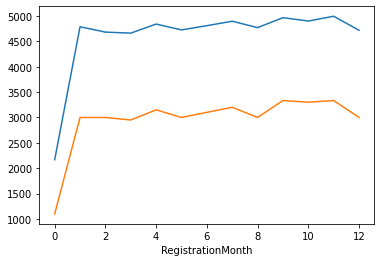

In [29]:
month_price['Price']['mean'].plot(ax=plt.gca())
month_price['Price']['median'].plot(ax=plt.gca())

В данных о месяце есть нулевой месяц - пропуск. Для остальных месяцев 1-12 - медиана и среднее без значительных отклонений. Посмотрим на распределение цены по месяцам 1-12.

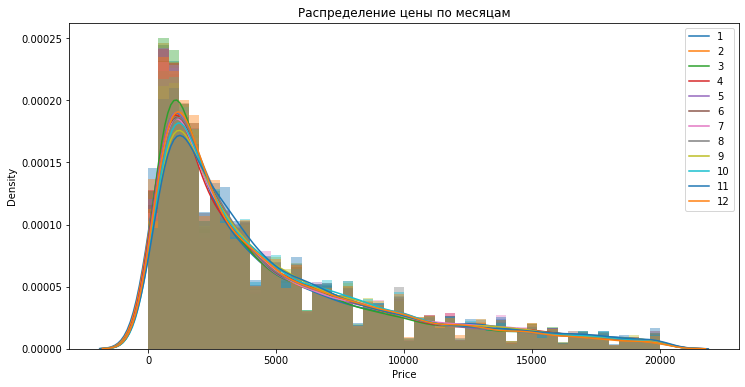

In [30]:
fig, ax = plt.subplots(1, figsize=(12,6))
legend = []
for month, data in autos[autos.RegistrationMonth != 0].groupby('RegistrationMonth'):
  sns.distplot(data.Price, ax=ax);
  legend.append(month)
ax.legend(legend)
ax.set_title('Распределение цены по месяцам');

Из распределения видно, цена не зависит от месяца регистрации. Удалим признак *RegistrationMonth*.

In [31]:
autos.drop(columns=['RegistrationMonth'], inplace=True)

#### RegistrationYear

Добавим признак года создания анкеты и сравним с датой регистрации машин.

In [32]:
autos['DateCreated'] = autos.DateCreated.astype('datetime64')
autos['YearCreated'] = autos.DateCreated.dt.year

print(autos.RegistrationYear.describe(), '\n')
print(autos.YearCreated.describe())

count    343597.000000
mean       2004.089797
std          78.413225
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64 

count    343597.000000
mean       2015.999921
std           0.009187
min        2014.000000
25%        2016.000000
50%        2016.000000
75%        2016.000000
max        2016.000000
Name: YearCreated, dtype: float64


Из описания данных года создания анкеты и года реистрации автомобиля на сайте следует, что есть аномальные значения для признака *RegistrationYear* - больше 2016.

In [33]:
print(autos.shape)
mask = (autos.RegistrationYear > 2016)
print('Удаляем', round(autos[mask].shape[0] / autos.shape[0] * 100, 2), "% данных")
autos.drop(autos[mask].index, inplace=True)
print(autos.shape)

(343597, 15)
Удаляем 4.01 % данных
(329818, 15)


Удалим объекты, год регистрации которых старше 1930 года, так как ретро автомобили также могут быть востребованы, а в поставленной задаче этот файт не уточняется.

In [34]:
print(autos.shape)
mask = (autos.RegistrationYear < 1930)
print('Удаляем', round(autos[mask].shape[0] / autos.shape[0] * 100, 2), "% данных")
autos.drop(autos[mask].index, inplace=True)
print(autos.shape)

(329818, 15)
Удаляем 0.04 % данных
(329696, 15)


count    329696.000000
mean       2002.612273
std           6.806320
min        1930.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: RegistrationYear, dtype: float64


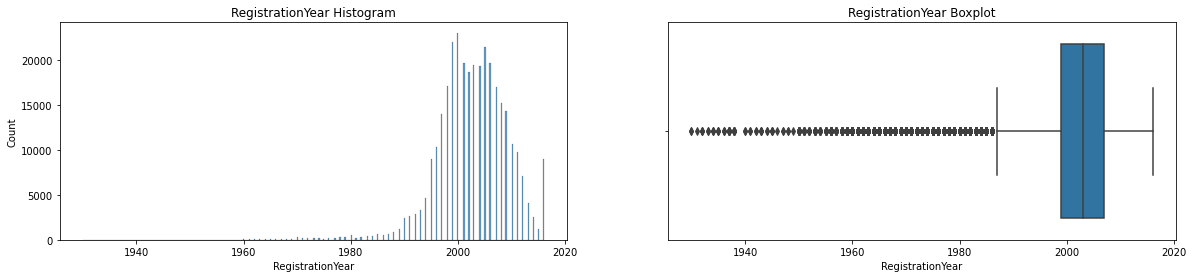

In [35]:
hist_box(autos, 'RegistrationYear', size=(20, 4), alpha=0.7)

Удалим столбцы с датой, почтовым индексом (в задаче этот признак не важен).

#### Power

На 2016 год наиболее мощные автомобили имели ~360-370 лошадиных сил. Поэтому определим верхнуюю границу признака как 370 и удалим аномалии.

In [36]:
print(autos.shape)
mask = (autos.Power > 370)
print('Удаляем', round(autos[mask].shape[0] / autos.shape[0] * 100, 2), "% данных")
autos.drop(autos[mask].index, inplace=True)
print(autos.shape)

(329696, 15)
Удаляем 0.26 % данных
(328837, 15)


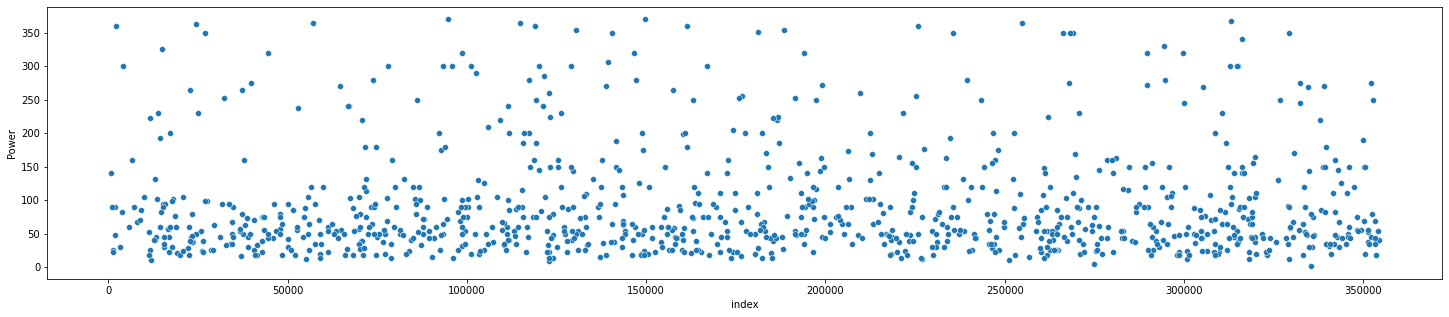

In [37]:
fig, ax = plt.subplots(1, figsize=(25, 5))
year_power = autos[autos.Power > 0].sort_values('RegistrationYear')[['Power']][:1000].reset_index()
sns.scatterplot(data=year_power, x='index', y="Power", ax=ax);

Из графика видно, что на протяжении всего времени присутствуют выбросы. Удалим выбросы в группировке по годам.

In [38]:
print(autos.shape)

for year, data in autos.groupby('RegistrationYear'):
  a, b = get_true_range(data.Power)
  index = data[(data.Power < a) | (data.Power > b)].index
  autos.drop(index, inplace=True) 

print(autos.shape)

(328837, 15)
(322017, 15)


count    322017.000000
mean        104.826506
std          56.046278
min           0.000000
25%          69.000000
50%         105.000000
75%         140.000000
max         340.000000
Name: Power, dtype: float64


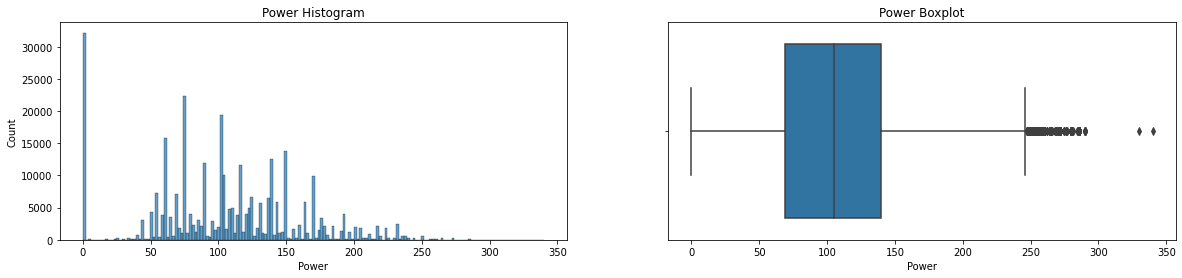

In [39]:
hist_box(autos, 'Power', size=(20, 4), alpha=0.7)

В работе будет решаться задача регрессии в отрыве от конкретного времени, поэтому удалим признаки с датами и почтовый индекс: *DateCrawled, DateCreated, LastSeen, PostalCode*.

count    322017.000000
mean     128235.978225
std       37432.168987
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64


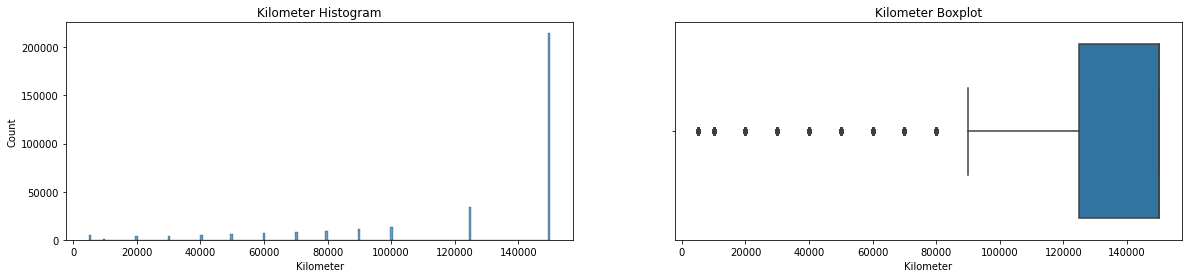

In [40]:
hist_box(autos, 'Kilometer', size=(20, 4), alpha=0.7)

In [41]:
# удаляем  ненужные столбцы
autos.drop(columns=['DateCrawled', 'DateCreated', 'LastSeen',
                    'PostalCode'], inplace=True)

In [42]:
# создадим списки признаков по типу
categorical = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']
countable = ['Price',	'RegistrationYear', 'Power', 'Kilometer']

### Пропуски

Посмотрим на данные о брендах и моделях.

In [43]:
autos.Brand.value_counts().sort_index()

alfa_romeo         2142
audi              26473
bmw               33077
chevrolet          1523
chrysler           1276
citroen            4770
dacia               841
daewoo              503
daihatsu            748
fiat               8817
ford              23268
honda              2575
hyundai            3359
jaguar              311
jeep                602
kia                2286
lada                203
lancia              432
land_rover          498
mazda              5234
mercedes_benz     28388
mini               3041
mitsubishi         2783
nissan             4477
opel              36524
peugeot           10397
porsche             453
renault           16342
rover               436
saab                483
seat               6295
skoda              5267
smart              4933
sonstige_autos     2364
subaru              671
suzuki             2195
toyota             4335
trabant             482
volkswagen        70244
volvo              2969
Name: Brand, dtype: int64

Посмотрим, есть бренды, для которых полностью не известны модели.

In [44]:
for brand, data in autos.groupby('Brand'):
  models = data.Model.unique()
  if len(models) == 1:
    print(brand, models, f'{len(data)/len(autos)*100}%')

sonstige_autos [nan] 0.7341227326507607%


sonstige_autos - группа неизвестных брендов, удалим их из таблицы.

In [45]:
print(autos.shape)
autos.drop(autos[autos.Brand == 'sonstige_autos'].index, inplace=True)
# autos.Brand.value_counts().sort_index()
print(autos.shape)

(322017, 11)
(319653, 11)


Заполним пропуски в категориальных признаках.

In [46]:
# сохраним копию чтобы потом вернуть наны
autos_tmp = autos.copy()

# заглушки на наны
autos[categorical] = autos[categorical].fillna('NAN')

# закодируем категориальные переменные (порядковое кодирование)
enc, autos = encode_data(autos, categorical)

# вернем наны обратно (чтобы заполнить значениями потом с помощью KNN)
for cat in categorical:
  nan_index = autos_tmp[autos_tmp[cat].isna()].index
  autos.loc[nan_index, [cat]] = np.nan

In [47]:
print(check_df_nan(autos), '\n')

             percentage data_type
NotRepaired        18.1   float64
FuelType            7.2   float64
VehicleType         6.0   float64
Gearbox             4.6   float64
Model               3.9   float64 



In [48]:
%%time
# заполнять пропуски будем в группировке по бренду - так быстрее и точнее, так как
# не ошибемся с брендом

autos_tmp = autos.copy()
for brand, data in autos_tmp.groupby('Brand'):
  index = data.index
  columns = data.columns
  imputer = KNNImputer(n_neighbors=3)
  autos_tmp.loc[index, columns] = imputer.fit_transform(data)

CPU times: user 3min 33s, sys: 11.1 s, total: 3min 44s
Wall time: 3min 18s


In [49]:
# приводим к читаемому виду обратно
autos[categorical] = enc.inverse_transform(autos_tmp[categorical])
autos.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,YearCreated
0,480,sedan,1993,manual,0,golf,150000,petrol,volkswagen,no,2016
1,18300,coupe,2011,manual,190,colt,125000,gasoline,audi,yes,2016
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,no,2016
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,2016
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no,2016


Заполним нули в данных о мощности в группировке.

In [50]:
print(autos[autos.Power == 0].shape)

for group in ['RegistrationYear', 'Brand']:
  for _, data in autos.groupby([group]):
    index = data[data.Power == 0].index
    autos.loc[index, 'Power'] = data.Power.median()

print(autos[autos.Power == 0].shape)

(31312, 11)
(0, 11)


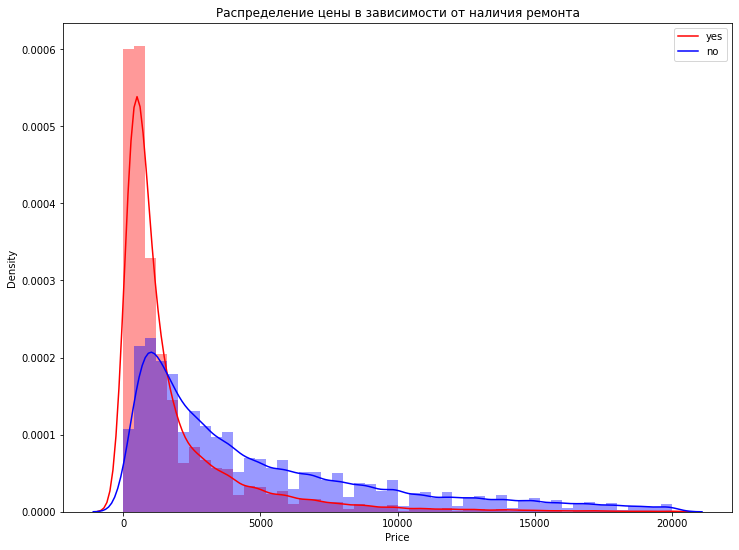

In [51]:
fig, ax = plt.subplots(1, figsize=(12,9))
sns.distplot(autos[autos.NotRepaired == 'yes']['Price'], color='red');
sns.distplot(autos[autos.NotRepaired == 'no']['Price'], color='blue');
plt.legend(['yes', 'no'])
plt.title('Распределение цены в зависимости от наличия ремонта');

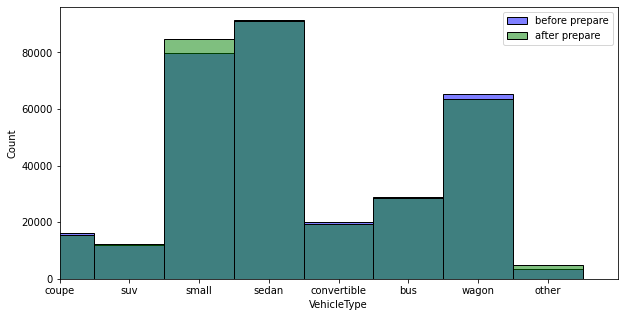

In [52]:
cat_hist(autos_orig, autos, 'VehicleType')

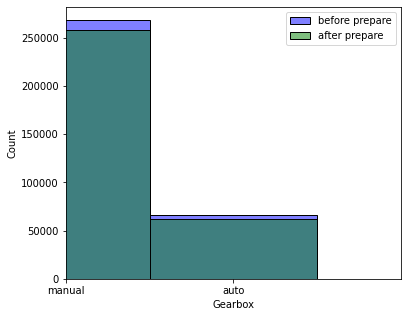

In [53]:
cat_hist(autos_orig, autos, 'Gearbox', size=(6, 5))

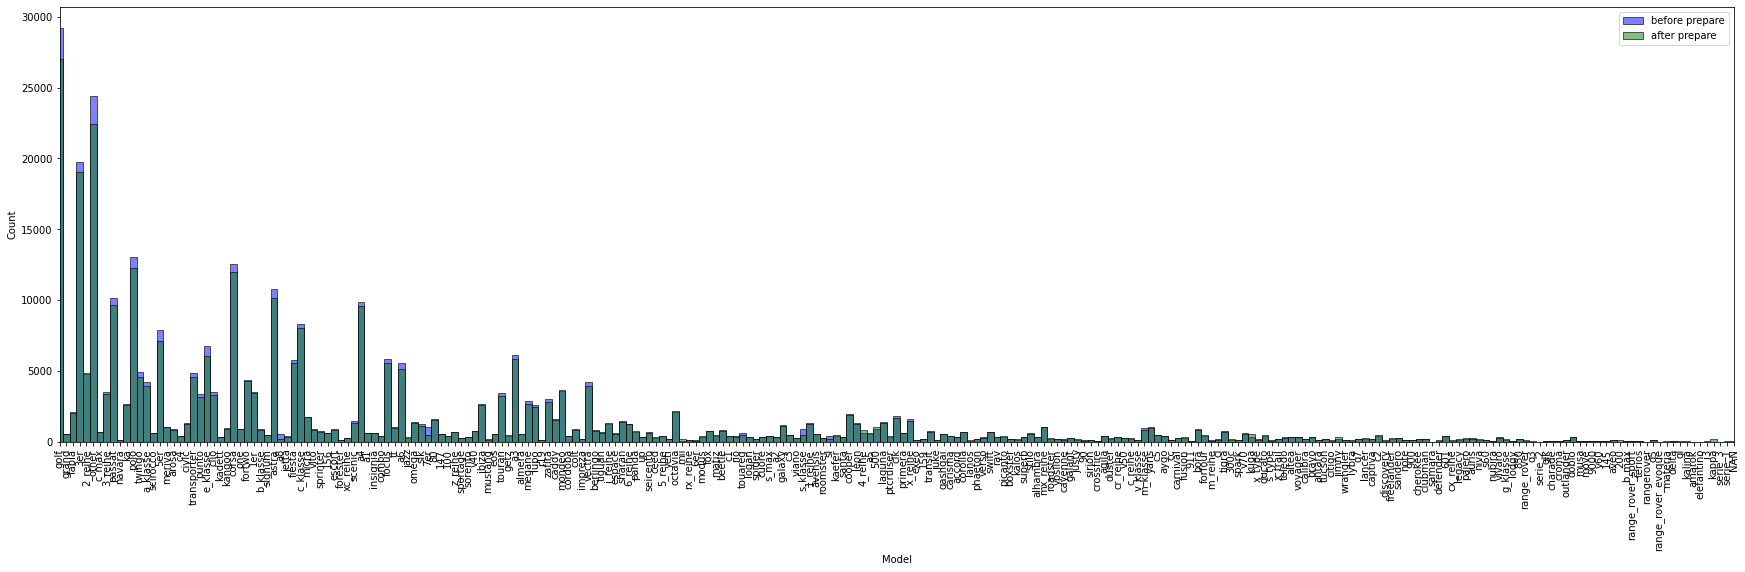

In [54]:
cat_hist(autos_orig, autos, 'Model', size=(30, 8), rot=90)

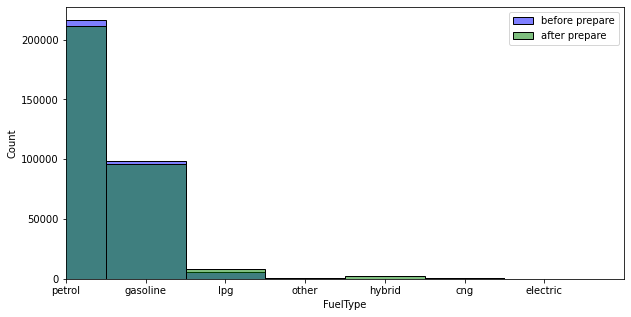

In [55]:
cat_hist(autos_orig, autos, 'FuelType')

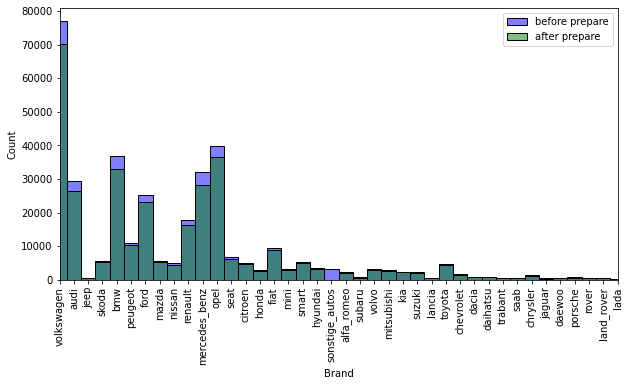

In [56]:
cat_hist(autos_orig, autos, 'Brand', rot=90)

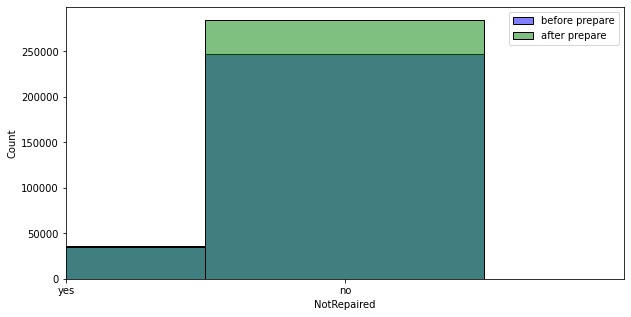

In [57]:
cat_hist(autos_orig, autos, 'NotRepaired')

In [58]:
n = len(autos_orig)
m = len(autos)
print("В результате обработки удалено {}% данных".format( round((n-m)/n*100, 1) ))

В результате обработки удалено 9.8% данных


## 5. Обучение моделей

In [59]:
train_time = OrderedDict()

In [60]:
autos[categorical] = autos[categorical].astype('category')
autos[categorical].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 319653 entries, 0 to 354368
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   VehicleType  319653 non-null  category
 1   Gearbox      319653 non-null  category
 2   Model        319653 non-null  category
 3   FuelType     319653 non-null  category
 4   Brand        319653 non-null  category
 5   NotRepaired  319653 non-null  category
dtypes: category(6)
memory usage: 14.6 MB


In [61]:
# для работы алгоритмов XGBoost нужно закодировать данные
autos_tmp = autos.copy()
enc, autos_tmp = encode_data(autos_tmp, categorical)
X_train_enc, y_train_enc, y_train_const_enc, X_test_enc, y_test_enc, y_test_const_enc = split_data(
    autos_tmp, 'Price', func='mean')

# для CatBoost, LightGBM
X_train, y_train, y_train_const, X_test, y_test, y_test_const = split_data(
    autos, 'Price', func='mean')

(223757, 10) (223757,)
(95896, 10) (95896,)
(223757, 10) (223757,)
(95896, 10) (95896,)


### XGBoost

[22:03:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 2min 14s, sys: 357 ms, total: 2min 15s
Wall time: 2min 15s


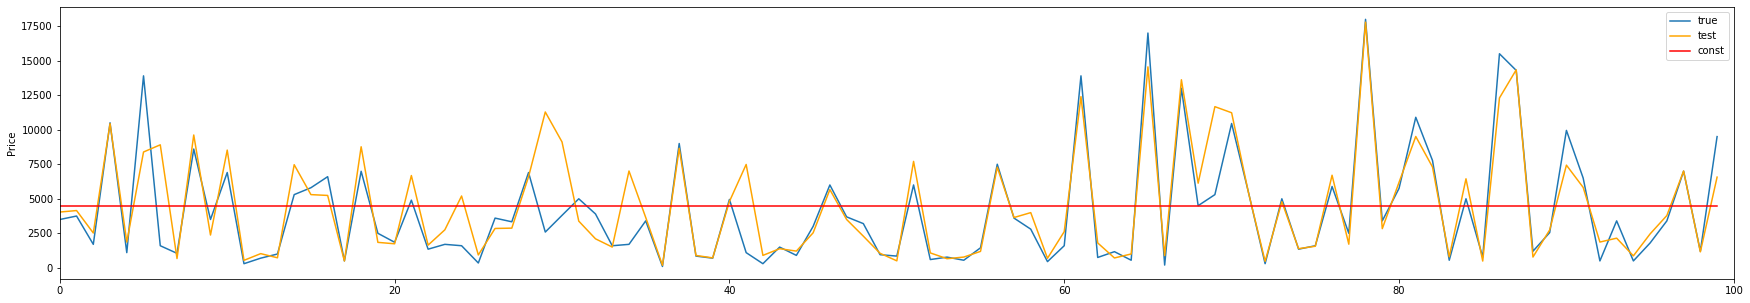

In [62]:
%%time

xgb_param_best = {'booster': 'gbtree',
 'eta': 0.1,
 'eval_metric': 'rmse',
 'lambda': 5.0,
 'max_depth': 20
 }

# fit
xgb_best, t = train_best(XGBRegressor(**xgb_param_best), X_train_enc, y_train_enc)
train_time['xgb_best'] = t

# predict
xgb_result = pd.DataFrame(predict_result(
    xgb_best, X_train_enc, X_test_enc, y_train_enc, y_test_enc, 
    y_train_const_enc, y_test_const_enc, n=100))

In [63]:
# result
print('time:', t)
xgb_result

time: 102.23054101699745


,train,test
rmse,845.598200,1614.065700
const,4439.205400,4437.896600
time,23.260641,9.667147


### LightGBM

CPU times: user 36.1 s, sys: 119 ms, total: 36.2 s
Wall time: 36.2 s


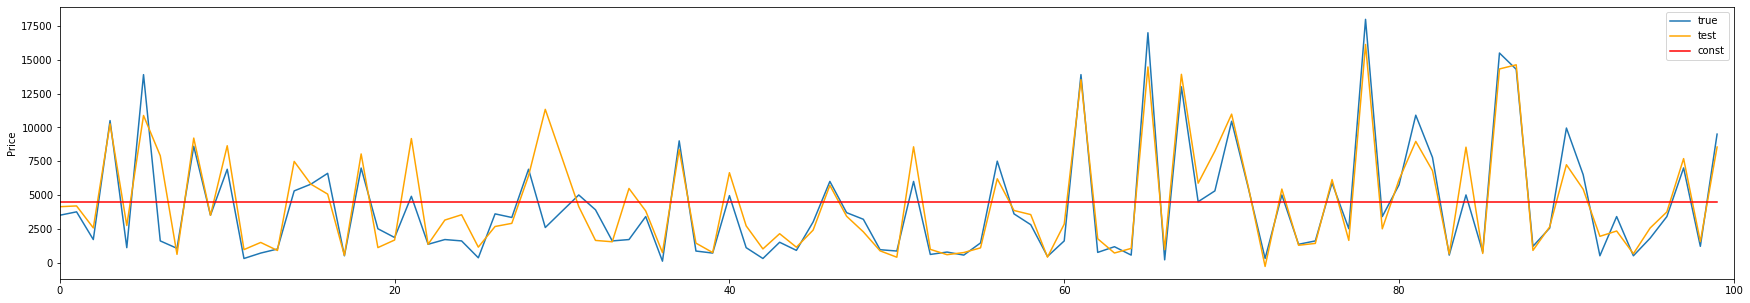

In [64]:
%%time

lgbm_param_best = {'boosting_type': 'gbdt',
 'learning_rate': 0.1,
 'max_depth': 50,
 'n_estimators': 1000,
 'min_child_samples': 40,
 'reg_alpha': 2,
 'reg_lambda': 5
 }

# fit
lgbm_best, t = train_best(LGBMRegressor(categorical_feature=categorical, **lgbm_param_best), X_train, y_train)
train_time['lgbm_best'] = t

# predict
lgbm_result = pd.DataFrame(predict_result(
    lgbm_best, X_train, X_test, y_train, y_test, y_train_const, y_test_const, n=100))

In [65]:
# result
print('time:', t)
lgbm_result

time: 10.929274632002489


,train,test
rmse,1336.145600,1501.180200
const,4439.205400,4437.896600
time,17.591026,7.614734


### Catboost

0:	learn: 4111.6277717	total: 1.4s	remaining: 2m 18s
10:	learn: 2361.6665808	total: 10.2s	remaining: 1m 22s
20:	learn: 1823.5253903	total: 18.8s	remaining: 1m 10s
30:	learn: 1663.7505057	total: 27.5s	remaining: 1m 1s
40:	learn: 1571.1223994	total: 36.2s	remaining: 52s
50:	learn: 1527.7193425	total: 44.8s	remaining: 43s
60:	learn: 1496.0798148	total: 53.4s	remaining: 34.2s
70:	learn: 1467.7108841	total: 1m 2s	remaining: 25.4s
80:	learn: 1448.2302024	total: 1m 10s	remaining: 16.6s
90:	learn: 1429.7907025	total: 1m 19s	remaining: 7.88s
99:	learn: 1415.7465452	total: 1m 26s	remaining: 0us
time: 87.95140530199933


,train,test
rmse,1431.907900,1584.897000
const,4439.205400,4437.896600
time,0.351279,0.156886


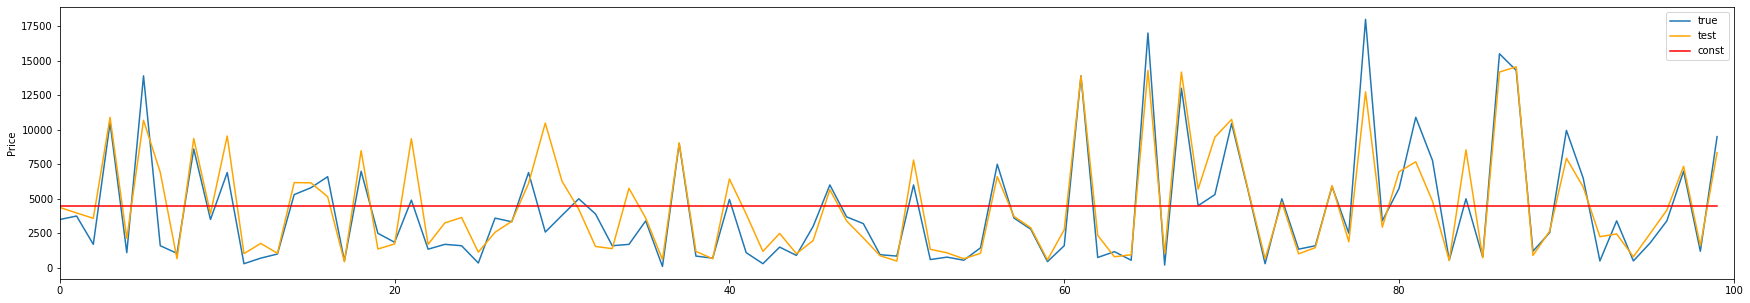

In [66]:
cbr_param_best = {
 'depth': 16,
 'iterations': 100,
 'learning_rate': 0.1,
 'reg_lambda': 5.0
 }


cbr_best, t = train_best(CatBoostRegressor(cat_features=categorical, verbose=10, **cbr_param_best), X_train, y_train)
train_time['cbr_best'] = t

cbr_result = pd.DataFrame(predict_result(
    cbr_best, X_train, X_test, y_train, y_test, 
    y_train_const, y_test_const, n=100))
print('time:', t)
cbr_result

### RandomForest



time: 60.63137251599983


,train,test
rmse,1007.86400,1555.387000
const,4439.20540,4437.896600
time,6.74247,2.926695


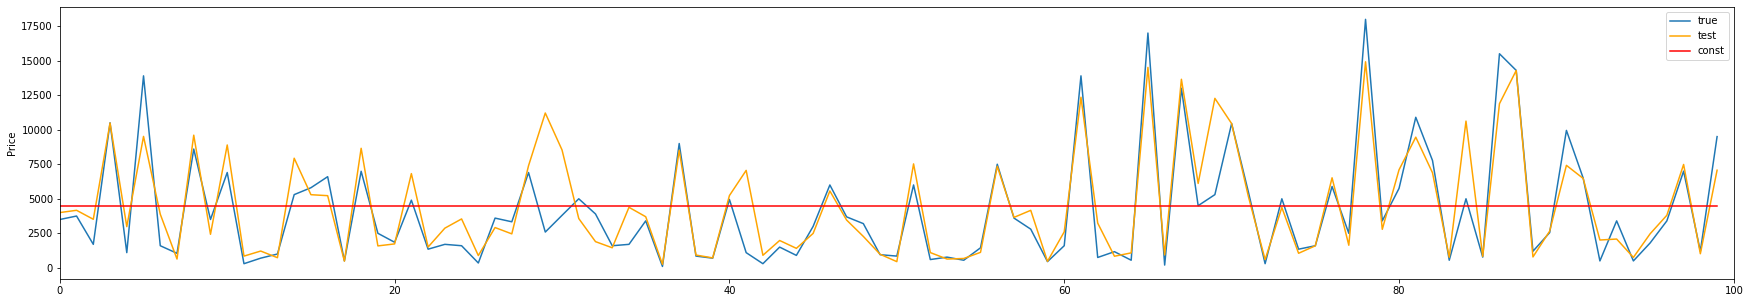

In [67]:
rf_params_best = {
    'n_estimators': 100,
    'max_depth': 20
}

rf_best, t = train_best(RandomForestRegressor(**rf_params_best), X_train_enc, y_train_enc)
train_time['rf_best'] = t

rf_result = pd.DataFrame(predict_result(
    rf_best, X_train_enc, X_test_enc, y_train_enc, y_test_enc, 
    y_train_const_enc, y_test_const_enc, n=100))
print('time:', t)
rf_result

In [68]:
rf_result

,train,test
rmse,1007.86400,1555.387000
const,4439.20540,4437.896600
time,6.74247,2.926695


## 6. Анализ моделей

In [69]:
result = xgb_result.join(lgbm_result, lsuffix='_xgb', rsuffix='_lgbm').join(cbr_result, rsuffix='_cbr').join(rf_result, rsuffix='_rf').reset_index()
result.set_axis(['param', 'train_xgb', 'test_xgb', 'train_lgbm', 'test_lgbm', 'train_cbr', 'test_cbr', 'train_rf', 'test_rf'], axis=1, inplace=True)
result

,param,train_xgb,test_xgb,train_lgbm,test_lgbm,train_cbr,test_cbr,train_rf,test_rf
0,rmse,845.598200,1614.065700,1336.145600,1501.180200,1431.907900,1584.897000,1007.86400,1555.387000
1,const,4439.205400,4437.896600,4439.205400,4437.896600,4439.205400,4437.896600,4439.20540,4437.896600
2,time,23.260641,9.667147,17.591026,7.614734,0.351279,0.156886,6.74247,2.926695


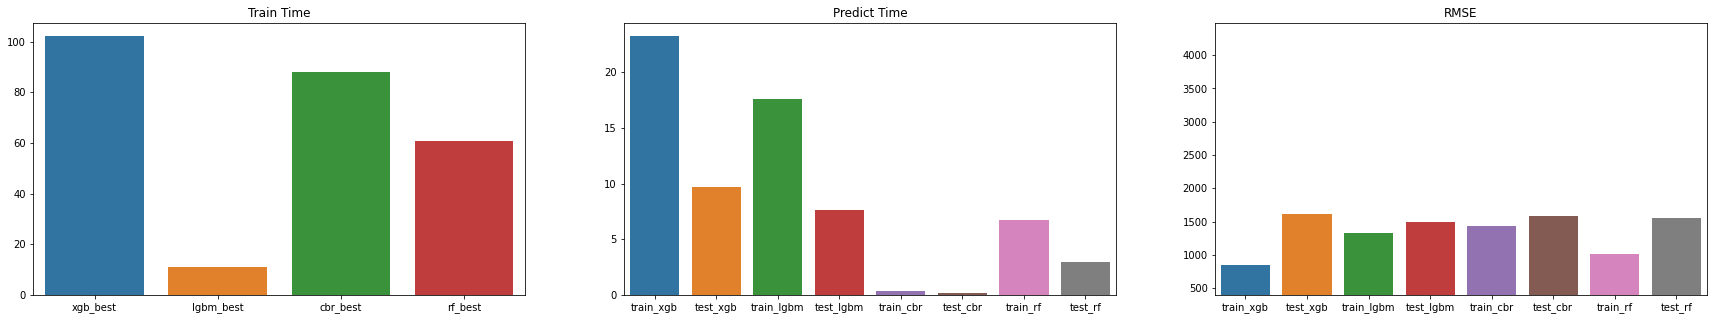

In [70]:
fig, axes = plt.subplots(1, 3, figsize=(30, 5))
sns.barplot(data=pd.DataFrame([train_time]), ax=axes[0])
axes[0].set_title('Train Time')
sns.barplot(data=result[result.param == 'time'], ax=axes[1])
axes[1].set_title('Predict Time')
sns.barplot(data=result[result.param == 'rmse'], ax=axes[2])
axes[2].set_title('RMSE')
axes[2].set_ylim(400, y_test_const[0])
plt.show()

## Вывод

В качестве рабочей модели выбран алгоритм CatBoost:
* Большее время обучения, но меньшее время предсказания (по сравнению с lightgbm)
* Оптимальное значение RMSE по сравнению с остальными моделями
* Меньшие затраты на предобработку данных (не нужно кодирование)
* Наименьший показатель переобучения
